In [1]:
using CSV
using DataFrames
#include("vapour.jl")
include("./room.jl")
include("./wall.jl")
include("./opening.jl")
include("./climate.jl")

reset_climate_data (generic function with 1 method)

# 建物内回路網モデル
# BNM(Building Network Model)

## 1. 建物内の熱水分移動構造と部屋の構成要素

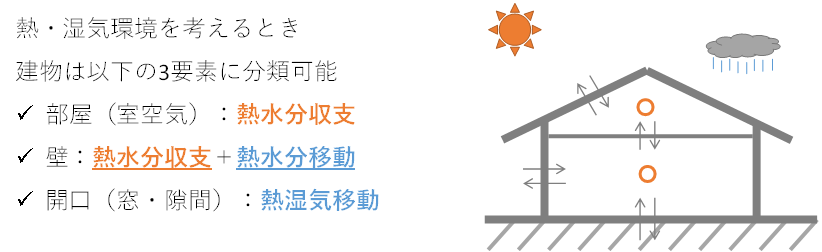


※コメント：定常熱伝導問題であれば熱貫流率さえ与えれば計算が可能にできると良い。

## 2. 建物内回路網モデルに必要なネットワーク構造

### 2.1 室内のネットワーク

室内のネットワーク構造は、後述の2.2同様、各空間に対し、どのような室が連結しているかを考慮することで作成することが出来る。  
一方、2024/1 時点において、このネットワーク構造は解析上不要であるため未作成である。  
壁・湿気移動を定常とみなす場合、この構造が重要になるものと考えられる。

In [2]:
Base.@kwdef mutable struct BNM
    rooms::Array{Room, 1}       = [] # 室内空間
    walls::Array{Wall, 1}       = [] # 壁体構成
    openings::Array{Opening, 1} = [] # 開口
    climate::Climate            = [] # 外界気象
    IC_walls::Array{Int}         = [] # インシデンス行列
    IC_openings::Array{Int}      = [] # インシデンス行列
end

BNM

### 2.2 インシデンス行列（結合行列）  

室のつながりののグラフ（ネットワーク）はインシデンス行列によって示すことが出来る。  
その基本的な概念とした、松下敬幸先生の授業資料を示す。

<img src="picture/incidence_matrix.PNG" width="100%">  

既約インシデンスというよりインシデンス行列全体を求めている。  
節点番号が行、枝番号が列を表す。
- RM：室の数（外気含めず）
- BC：枝数
- IP：上流側室番号
- IM：下流側室番号

In [ ]:
function cal_IC( RM::Int, BC::Int, IP::Array, IM::Array )
    # RM+1であるので外気を含めたインシデンス行列を求めている。
    IC = zeros( Int, RM+1, BC )
    for i = 1 : BC
        IC[ IP[i], i] = Int(1)
        IC[ IM[i], i] = Int(-1)
    end
    return IC
end
cal_IC(; RM::Int, BC::Int, IP::Array, IM::Array ) = cal_IC( RM, BC, IP::Array, IM::Array )

In [ ]:
構造体を用いた形式
function cal_IC( rooms::Array{Room, 1}, openings::Array{Opening, 1} )
    return cal_IC( 
        RM = length(rooms), 
        BC = length(openings), 
        IP = [ openings[i].IP for i = 1:length(openings)], 
        IM = [ openings[i].IM for i = 1:length(openings)] )
end
#cal_IC(;NC::Network_configuration_VENT, OC::Array{Opening, 1} ) = cal_IC(NC,OC)

## 3. データセットの入力

建物内のネットワーク構造（BNM：Building Network Model）の入力方法について示す。  
ここでは上述のBNM構造体のうち、以下の変数をデータセットから入力するものである。  
- rooms
- walls
- openings
- climate

なお、各変数のデータセットの入力方法は各ファイル内で説明するものとする。  
本関数では、各データセットを入力した際の統合方法、すなわちroomとwallの繋がりを決定することが主な目的である。


In [ ]:
function create_BNM_model(;file_name_rooms::String, file_name_walls::String, file_name_openings::String, file_name_climate::String, 
    header_room::Int = 3, header_wall::Int = 3, header_opening::Int = 3, header_climate::Int = 3)
    # ファイルの読み込み
    climate  = input_climate_data(file_name_climate, header_climate)
    rooms    = input_room_data(file_name_rooms, header_room)
    walls    = input_wall_data(file_name_walls, header_wall)
    openings = input_opening_data(file_name_openings, header_opening)
    
    # roomデータの1番目をclimateのair情報とリンクさせる。（換気回路網計算では床面圧力が必要なため、roomを入力値とする必要あり。）
    rooms[1].air = climate.air
    
    # wallデータ内のair情報をroom情報のairとリンクさせる。
    for i = 1 : length(walls)
        try 
            walls[i].BC_IP.air = rooms[walls[i].IP].air
        catch
            println(" 壁番号 = ", i, ", IP = ", walls[i].IP )
            println("は第一種あるいは第二種境界条件です。" )
        end
        try 
            walls[i].BC_IM.air = rooms[walls[i].IM].air
        catch
            println(" 壁番号 = ", i, ", IM = ", walls[i].IM )
            println("は第一種あるいは第二種境界条件です。" )
        end
    end

    # openingデータ内の上流側・下流側の情報をroomあるいはclimateとリンクさせる。
    for i = 1 : length(openings)
        openings[i].room_IP = rooms[openings[i].IP]
        openings[i].room_IM = rooms[openings[i].IM]
    end

    # インシデンス行列の作成
    # 室ー壁間のインシデンス行列
    IC_walls = zeros( length(rooms), length(walls) )
    for i = 1 : length(walls)
        # 第一,二種境界条件を除く
        if walls[i].IP ≠ 0 && walls[i].IP ≠ -1
            IC_walls[ walls[i].IP, i] = +1.0
        end
        if walls[i].IM ≠ 0 && walls[i].IM ≠ -1
            IC_walls[ walls[i].IM, i] = -1.0
        end
    end

    # 室ー枝間のインシデンス行列
    IC_openings = zeros( length(rooms), length(openings) )
    for i = 1 : length(openings)
        IC_openings[ openings[i].IP, i] = +1.0
        IC_openings[ openings[i].IM, i] = -1.0
    end

    # Building Network Modelの構築
    network = BNM( rooms = rooms, walls = walls, openings = openings, climate = climate, IC_walls = IC_walls, IC_openings = IC_openings )

    return network
end

create_BNM_model (generic function with 1 method)

In [4]:
# 読み込み例
sample_network = create_BNM_model(
    file_name_rooms     = "../input_data/building_network_model/room_condition.csv", 
    file_name_walls     = "../input_data/building_network_model/wall_condition.csv", 
    file_name_openings  = "../input_data/building_network_model/opening_condition.csv",
    file_name_climate   = "../input_data/climate_data/sample_climate_data.csv")

IP = 0, IM = 2
いずれかの室番号が無いか、第一種境界条件です。
IP = -1, IM = 3
いずれかの室番号が無いか、第一種境界条件です。


BNM(Room[Room(1, "outdoor", Air(0, "climate", 0.0, 0.0, 0.0, 0.0, 276.84999999999997, 0.77, 613.2898775721085, 0.0037877055546582487, 101325.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, "OFF"), Room(2, "underfloor", Air(0, "underfloor", 0.0, 0.0, 0.0, 80.0, 283.15, 0.6, 0.0, 0.0, 101325.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, "OFF"), Room(3, "room1", Air(0, "room1", 0.0, 0.0, 0.0, 125.0, 283.15, 0.6, 0.0, 0.0, 101325.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, "OFF"), Room(4, "room2", Air(0, "room2", 0.0, 0.0, 0.0, 125.0, 283.15, 0.6, 0.0, 0.0, 101325.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, "OFF")], Wall[Wall(1, "ground", 0, 2, 0.0, 0.2, 100.0, 0.0, 0.0, Cell[Cell([1, 1, 1], [0.0, 0.0, 0.0], 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 283.15, -66807.7360789275, 0.0, 0.0, 0.0, 101325.0, "sandy_clay_loam", [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0

In [5]:
sample_network.IC_walls[1,:]

13-element Vector{Int64}:
 0
 1
 1
 1
 1
 1
 1
 0
 0
 1
 0
 1
 0

In [6]:
sample_network.IC_openings

5×6 Matrix{Int64}:
  1   1   0   1   0   0
 -1   0   1   0   1   0
  0  -1  -1   0   0   1
  0   0   0  -1  -1  -1
  0   0   0   0   0   0